In [2]:
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import os
import time
import sklearn.metrics as skmet
import torch
import asdf
import pickle
import scipy.integrate as sintg
import gc

import tools
import importlib
importlib.reload(tools)
device="cuda"

In [3]:
dats={}
dats["MAIN"]=tools.load_NGC(fp="./exgal_catalogs/object_sdss_spectro.fits",ra="PLUG_RA",dec="PLUG_DEC",cuts={"OBJTYPE":lambda x:x=="GALAXY"})
dats["LOWZ"]=tools.load_NGC(fp="./exgal_catalogs/galaxy_DR12v5_LOWZ_North.fits.gz")
dats["CMASS"]=tools.load_NGC(fp="./exgal_catalogs/galaxy_DR12v5_CMASS_North.fits.gz")
dats["QSO"]=tools.load_NGC(fp="./exgal_catalogs/eBOSS_QSO_full_ALLdata-vDR16.fits")

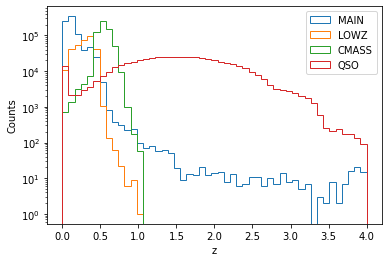

In [4]:
bins=np.linspace(0,4,50)
for name,dat in dats.items():
    _=plt.hist(dat[:,2],bins=bins,histtype="step",label=name)
plt.yscale("log")
plt.xlabel("z")
plt.ylabel("Counts")
plt.legend()

In [5]:
dat=np.zeros((0,3))
for key,dat_ in dats.items():
    if len(dat)==0:
        dat=np.append(dat,dat_,axis=0)
        continue
        
    current=SkyCoord(l=dat[:,0]*u.degree, b=dat[:,1]*u.degree, frame='galactic')
    c=SkyCoord(l=dat_[:,0]*u.degree, b=dat_[:,1]*u.degree, frame='galactic')
    idx,sep2d,_=c.match_to_catalog_sky(current)
    new=sep2d>(0.5*u.arcsec)
    print("Removing",len(c)-new.sum())
    dat=np.append(dat,dat_[new],axis=0)
vecs=hp.ang2vec(dat[:,0],dat[:,1],lonlat=True)
dat=np.concatenate([dat,vecs],axis=1)
dat.shape

Removing 138524
Removing 15385
Removing 14


(2153690, 6)

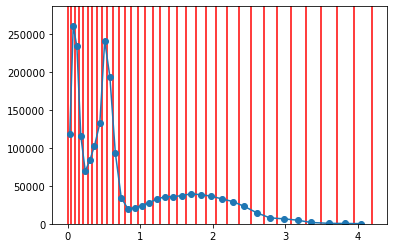

In [6]:
N_bins=34
zbinedges=np.logspace(np.log10(1),np.log10(5.2),N_bins+1,base=10)-1
inds=np.digitize(dat[:,2],zbinedges)
z_binned=[dat[(inds==i)] for i in range(1,N_bins+1)]
#z_binned=[dat[inds==i] for i in range(1,N_bins+1)]
mean_z=[dat_[:,2].mean() for dat_ in z_binned]
n_samps=[dat_.shape[0] for dat_ in z_binned]
plt.plot(mean_z,n_samps,marker="o")
plt.ylim(0,np.max(n_samps)*1.1)
plt.vlines(zbinedges,*plt.gca().get_ylim(),color="r")

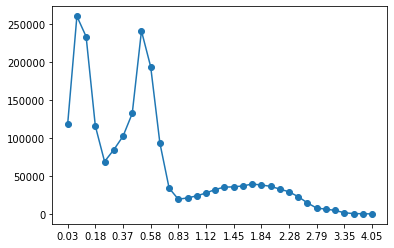

In [7]:
plt.plot(n_samps,marker="o")
sub=3
plt.xticks(np.arange(N_bins)[::sub])
plt.gca().set_xticklabels(np.round(mean_z,2)[::sub])
None

24.907635026830906 155.09236497316908 -65.0923649731691 65.0923649731691


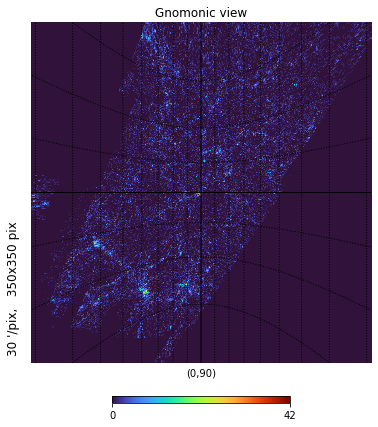

In [10]:
iz=0
NSIDE=256
NPIX = hp.nside2npix(NSIDE)
inds=hp.ang2pix(nside=NSIDE,theta=np.radians(90. - z_binned[iz][:,1]),phi=np.radians(z_binned[iz][:,0]))
idx, counts = np.unique(inds, return_counts=True)
hist=np.zeros(NPIX)
hist[idx]=counts

hp.gnomview(hist,rot=(0,90,0),xsize=350,reso=30,cmap="turbo")
hp.graticule()

In [12]:
def get_max_pixrad(nside):
    npix=hp.nside2npix(nside)
    angs=np.stack(hp.vec2ang(hp.boundaries(nside,np.arange(npix),step=1).transpose(0,2,1).reshape(-1,3),lonlat=True),axis=0).reshape(2,-1,4)
    centers=np.stack(hp.pix2ang(nside,np.arange(npix),lonlat=True),axis=0)
    thetas1=np.max(hp.rotator.angdist(angs[:,:,0],centers,lonlat=True))
    thetas2=np.max(hp.rotator.angdist(angs[:,:,1],centers,lonlat=True))
    thetas3=np.max(hp.rotator.angdist(angs[:,:,2],centers,lonlat=True))
    thetas4=np.max(hp.rotator.angdist(angs[:,:,3],centers,lonlat=True))
    return np.max([thetas1,thetas2,thetas3,thetas4])*u.rad

In [13]:
nside=2048
angbinedges_arcmin=np.logspace(np.log10(0.5),np.log10(180),14,base=10)
angbinedges_arcmin=np.append(np.zeros(1),angbinedges_arcmin)
angbinedges=(angbinedges_arcmin*u.arcmin).to(u.deg)
nside_mask_large=32
#searchrad=maxang+get_max_pixrad(nside//4)+get_max_pixrad(nside_mask_large)
searchrad=(5.03)*u.deg #nside_mask_large=32,nside=512

npix=hp.nside2npix(nside)
npix_mask_large=hp.nside2npix(nside_mask_large)
maxang=np.max(angbinedges)*1.001

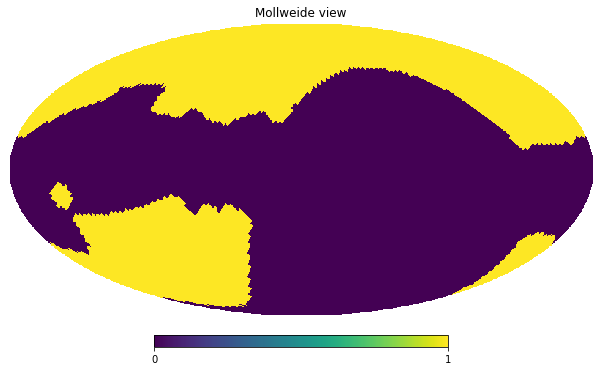

In [14]:
nside_mask_large=32
npix_mask_large=hp.nside2npix(nside_mask_large)
l_mask_large,b_mask_large=hp.pix2ang(nside_mask_large,np.arange(npix_mask_large),lonlat=True)
coords_mask_large=SkyCoord(l=l_mask_large*u.deg, b=b_mask_large*u.deg, frame='galactic')
coords_catalog=SkyCoord(l=dat[:,0]*u.deg, b=dat[:,1]*u.deg, frame='galactic')
#imask_large_with_source=np.unique(hp.ang2pix(nside_mask_large,dat[:,0],dat[:,1],lonlat=True))
idx,sep2d,_=coords_mask_large.match_to_catalog_sky(coords_catalog)
mask_large=sep2d.to(u.rad)<searchrad
imask_large=np.nonzero(mask_large)[0]
imask=tools.subpix(nside=nside_mask_large,ipix=imask_large,nsidesub=nside)
imask=imask.reshape(-1)
mask=np.zeros(npix,dtype=bool)
mask[imask]=1
hp.mollview(mask)

Save mask

In [15]:
np.save("./acc_temp_asdf/imask.npy",imask)

In [16]:
searchrad_rad=searchrad.to(u.rad).value
searchpix={}
for c,i in enumerate(imask_large):
    ipix=hp.query_disc(nside,hp.pix2vec(nside_mask_large,i),searchrad_rad,inclusive=True)
    vec_pix=np.stack(hp.pixelfunc.pix2vec(nside, ipix),axis=1)
    searchpix[i]=[torch.tensor(ipix,device=device),torch.tensor(vec_pix,device=device)]

In [48]:
n_bootstrap=10

args_list=[]
for ib in range(n_bootstrap):
    for iz in range(N_bins):
        key="iz="+str(iz)+"_"+"ib="+str(ib)
        n=len(z_binned[iz])
        randind=np.random.choice(n,n,replace=True)
        sourcevecs=z_binned[iz][randind,3:]
        sourceimasks=hp.vec2pix(nside_mask_large,*sourcevecs.T)
        sourcevecs=torch.tensor(sourcevecs,device=device)
        pars={}
        pars["nside"]=nside
        pars["sourceimasks"]=sourceimasks
        pars["sourcevecs"]=sourcevecs
        pars["angbinedges"]=angbinedges
        pars["device"]="cuda"
        args_list.append([key,pars])

In [18]:
def get_acc_weighting(nside,sourceimasks,sourcevecs,angbinedges,device="cpu"):
    assert angbinedges.unit==u.deg,"all units in degrees please"
    angbinedges_rad=torch.tensor(angbinedges.to(u.rad).value,device=device)
    n_binedges=len(angbinedges)

    exgal_map=torch.zeros((n_binedges-1,hp.nside2npix(nside)),device=device,dtype=torch.int64)
    
    for i,vec in zip(sourceimasks,sourcevecs):
        ipix,vec_pix=searchpix[i]
        thetas=torch.arccos(vec_pix@vec)
        inds=torch.bucketize(thetas,angbinedges_rad)
        notvalids=(inds==0)|(inds==n_binedges)
        inds-=1
        vals=torch.ones_like(inds,device=device,dtype=torch.int64)
        vals[notvalids]=0
        inds[notvalids]=0 #to avoid out of bound error
        exgal_map.index_put_((inds,ipix),vals,accumulate=True)
    return exgal_map

Test

In [73]:
st=time.time()
res=get_acc_weighting(nside=nside,sourceimasks=sourceimasks[:5000],sourcevecs=sourcevecs[:5000],angbinedges=angbinedges,device=device)
res=res.cpu().detach().numpy()
time.time()-st

5.825849533081055

In [36]:
def func(args):
    key=args[0]
    pars=args[1]
    res=get_acc_weighting(**pars)
    print(key,"done")
    return [key,res]

In [37]:
for args in args_list:
    try:
        name,res=func(args)
        res=res.cpu().detach().numpy()[:,imask]
        fn=os.path.join("./acc_temp_asdf/",name+".asdf")
        if os.path.exists(fn):
            os.remove(fn)
        ff = asdf.AsdfFile({"weight":res})
        ff.write_to(fn,all_array_compression="lz4")
        ff.close()
    except Exception as e:
        print(e)

iz=0_ib=0 done
iz=1_ib=0 done
iz=2_ib=0 done
iz=3_ib=0 done
iz=4_ib=0 done
iz=5_ib=0 done
iz=6_ib=0 done
iz=7_ib=0 done
iz=8_ib=0 done
iz=9_ib=0 done
iz=10_ib=0 done
iz=11_ib=0 done
iz=12_ib=0 done
iz=13_ib=0 done
iz=14_ib=0 done
iz=15_ib=0 done
iz=16_ib=0 done
iz=17_ib=0 done
iz=18_ib=0 done
iz=19_ib=0 done
iz=20_ib=0 done
iz=21_ib=0 done
iz=22_ib=0 done
iz=23_ib=0 done
iz=24_ib=0 done
iz=25_ib=0 done
iz=26_ib=0 done
iz=27_ib=0 done
iz=28_ib=0 done
iz=29_ib=0 done
iz=30_ib=0 done
iz=31_ib=0 done
iz=32_ib=0 done
iz=33_ib=0 done
iz=0_ib=1 done
iz=1_ib=1 done
iz=2_ib=1 done
iz=3_ib=1 done
iz=4_ib=1 done
iz=5_ib=1 done
iz=6_ib=1 done
iz=7_ib=1 done
iz=8_ib=1 done
iz=9_ib=1 done
iz=10_ib=1 done
iz=11_ib=1 done
iz=12_ib=1 done
iz=13_ib=1 done
iz=14_ib=1 done
iz=15_ib=1 done
iz=16_ib=1 done
iz=17_ib=1 done
iz=18_ib=1 done
iz=19_ib=1 done
iz=20_ib=1 done
iz=21_ib=1 done
iz=22_ib=1 done
iz=23_ib=1 done
iz=24_ib=1 done
iz=25_ib=1 done
iz=26_ib=1 done
iz=27_ib=1 done
iz=28_ib=1 done
iz=29_ib=1 d

Done

In [ ]:
info={"mean_z":np.array(mean_z),"angbinedges_arcmin":angbinedges.to(u.arcmin).value,"n_bootstrap":n_bootstrap,"nz":len(mean_z)}
with open("./acc_temp_asdf/info.pickle", 'wb') as f:
    pickle.dump(info,f)

Integral

In [35]:
with open("./acc_temp_asdf/info.pickle", 'rb') as f:
    info=pickle.load(f)
angbinedges_arcmin=info["angbinedges_arcmin"]
meanbins_arcmin=(angbinedges_arcmin[1:]+angbinedges_arcmin[:-1])/2
i_intg=7
print("Integral to",meanbins_arcmin[i_intg],"arcmin")
def get_intg_coeff(x):
    #laziest method ever don't even ask
    dset=np.random.randn(1024,len(x))
    dsetintg=sintg.trapezoid(dset,x)
    res=np.linalg.inv(dset.T@dset)@dset.T@dsetintg
    return res
coeff=get_intg_coeff(meanbins_arcmin[:i_intg+1])/meanbins_arcmin[i_intg]
coeff

Integral to 9.730981729553628 arcmin


array([0.02020189, 0.0391273 , 0.04868892, 0.07657179, 0.12042244,
       0.18938522, 0.29784118, 0.18207012])

In [24]:
masks={}
nside=2048
npix=hp.nside2npix(nside)

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=b>50
idustmapmask=np.nonzero(dustmapmask)[0]
masks["NGC"]=idustmapmask

idustmapmask=np.arange(npix)
masks["FULL"]=idustmapmask

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=(b<-30)*(l<220)*(l>30)
idustmapmask=np.nonzero(dustmapmask)[0]
masks["South"]=idustmapmask

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=(b>20)
idustmapmask=np.nonzero(dustmapmask)[0]
masks["North"]=idustmapmask

In [36]:
for maskingname,idustmapmask in masks.items():
    print("Doing",maskingname)
    imask=np.load("./acc_temp_asdf/imask.npy")
    commonmask=np.zeros(npix,np.uint8)
    commonmask[imask]+=1;commonmask[idustmapmask]+=1
    icommonmask=np.nonzero(commonmask==2)[0]

    buffer=np.full(npix,npix)
    uniques,indexes=np.unique(imask,return_index=True)
    buffer[uniques]=indexes
    iloading=buffer[icommonmask]

    buffer[...]=npix
    uniques,indexes=np.unique(idustmapmask,return_index=True)
    buffer[uniques]=indexes
    idustmap=buffer[icommonmask]

    ifinal=np.arange(npix)[icommonmask]
    del imask,commonmask,icommonmask,buffer,uniques,indexes
    
    for ib in range(info["n_bootstrap"]):
        print("ib=",ib)
        weights=[]
        for iz in range(info["nz"]):
            gc.collect()
            print(" iz=",iz)
            fn=os.path.join("./acc_temp_asdf/","iz="+str(iz)+"_"+"ib="+str(ib)+".asdf")
            with asdf.open(fn) as f:
                weight=np.array(f.tree["weight"][:i_intg+1,iloading])
            norms=weight.sum(1)
            weight=weight.astype(np.float64)/norms[:,None]
            weight=coeff@weight
            weights.append(weight)
        weights=np.stack(weights,axis=0)
        fn=os.path.join("./acc_temp_asdf/","intg_"+maskingname+"_"+"ib="+str(ib)+".asdf")
        if os.path.exists(fn):
            os.remove(fn)
        ff = asdf.AsdfFile({"weight":weights,"indices":ifinal})
        ff.write_to(fn,all_array_compression="lz4")
        ff.close()

Doing NGC
ib= 0
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
ib= 1
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
ib= 2
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
ib= 3
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 2

All

In [23]:
args_list=[]
for iz in range(N_bins):
    key="all_iz="+str(iz)
    sourcevecs=z_binned[iz][:,3:]
    sourceimasks=hp.vec2pix(nside_mask_large,*sourcevecs.T)
    sourcevecs=torch.tensor(sourcevecs,device=device)
    pars={}
    pars["nside"]=nside
    pars["sourceimasks"]=sourceimasks
    pars["sourcevecs"]=sourcevecs
    pars["angbinedges"]=angbinedges
    pars["device"]="cuda"
    args_list.append([key,pars])

In [24]:
def func(args):
    key=args[0]
    pars=args[1]
    res=get_acc_weighting(**pars)
    print(key,"done")
    return [key,res]

In [25]:
for args in args_list:
    try:
        name,res=func(args)
        res=res.cpu().detach().numpy()[:,imask]
        fn=os.path.join("./acc_temp_asdf/",name+".asdf")
        if os.path.exists(fn):
            os.remove(fn)
        ff = asdf.AsdfFile({"weight":res})
        ff.write_to(fn,all_array_compression="lz4")
        ff.close()
    except Exception as e:
        print(e)

all_iz=0 done
all_iz=1 done
all_iz=2 done
all_iz=3 done
all_iz=4 done
all_iz=5 done
all_iz=6 done
all_iz=7 done
all_iz=8 done
all_iz=9 done
all_iz=10 done
all_iz=11 done
all_iz=12 done
all_iz=13 done
all_iz=14 done
all_iz=15 done
all_iz=16 done
all_iz=17 done
all_iz=18 done
all_iz=19 done
all_iz=20 done
all_iz=21 done
all_iz=22 done
all_iz=23 done
all_iz=24 done
all_iz=25 done
all_iz=26 done
all_iz=27 done
all_iz=28 done
all_iz=29 done
all_iz=30 done
all_iz=31 done
all_iz=32 done
all_iz=33 done


In [26]:
with open("./acc_temp_asdf/info.pickle", 'rb') as f:
    info=pickle.load(f)
angbinedges_arcmin=info["angbinedges_arcmin"]
meanbins_arcmin=(angbinedges_arcmin[1:]+angbinedges_arcmin[:-1])/2
i_intg=7
print("Integral to",meanbins_arcmin[i_intg],"arcmin")
def get_intg_coeff(x):
    #laziest method ever don't even ask
    dset=np.random.randn(1024,len(x))
    dsetintg=sintg.trapezoid(dset,x)
    res=np.linalg.inv(dset.T@dset)@dset.T@dsetintg
    return res
coeff=get_intg_coeff(meanbins_arcmin[:i_intg+1])/meanbins_arcmin[i_intg]
coeff

Integral to 9.730981729553628 arcmin


array([0.02020189, 0.0391273 , 0.04868892, 0.07657179, 0.12042244,
       0.18938522, 0.29784118, 0.18207012])

In [27]:
masks={}
nside=2048
npix=hp.nside2npix(nside)

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=b>50
idustmapmask=np.nonzero(dustmapmask)[0]
masks["NGC"]=idustmapmask

idustmapmask=np.arange(npix)
masks["FULL"]=idustmapmask

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=(b<-30)*(l<220)*(l>30)
idustmapmask=np.nonzero(dustmapmask)[0]
masks["South"]=idustmapmask

l,b=hp.pix2ang(nside=nside,ipix=np.arange(npix),lonlat=True)
dustmapmask=(b>20)
idustmapmask=np.nonzero(dustmapmask)[0]
masks["North"]=idustmapmask

In [28]:
for maskingname,idustmapmask in masks.items():
    print("Doing",maskingname)
    imask=np.load("./acc_temp_asdf/imask.npy")
    commonmask=np.zeros(npix,np.uint8)
    commonmask[imask]+=1;commonmask[idustmapmask]+=1
    icommonmask=np.nonzero(commonmask==2)[0]

    buffer=np.full(npix,npix)
    uniques,indexes=np.unique(imask,return_index=True)
    buffer[uniques]=indexes
    iloading=buffer[icommonmask]

    buffer[...]=npix
    uniques,indexes=np.unique(idustmapmask,return_index=True)
    buffer[uniques]=indexes
    idustmap=buffer[icommonmask]

    ifinal=np.arange(npix)[icommonmask]
    del imask,commonmask,icommonmask,buffer,uniques,indexes
    
    weights=[]
    for iz in range(info["nz"]):
        gc.collect()
        print(" iz=",iz)
        fn=os.path.join("./acc_temp_asdf/","all_iz="+str(iz)+".asdf")
        with asdf.open(fn) as f:
            weight=np.array(f.tree["weight"][:i_intg+1,iloading])
        norms=weight.sum(1)
        weight=weight.astype(np.float64)/norms[:,None]
        weight=coeff@weight
        weights.append(weight)
    weights=np.stack(weights,axis=0)
    
    fn=os.path.join("./acc_temp_asdf/","all_intg_"+maskingname+".asdf")
    if os.path.exists(fn):
        os.remove(fn)
    ff = asdf.AsdfFile({"weight":weights,"indices":ifinal})
    ff.write_to(fn,all_array_compression="lz4")
    ff.close()

Doing NGC
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
Doing FULL
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
Doing South
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz= 22
 iz= 23
 iz= 24
 iz= 25
 iz= 26
 iz= 27
 iz= 28
 iz= 29
 iz= 30
 iz= 31
 iz= 32
 iz= 33
Doing North
 iz= 0
 iz= 1
 iz= 2
 iz= 3
 iz= 4
 iz= 5
 iz= 6
 iz= 7
 iz= 8
 iz= 9
 iz= 10
 iz= 11
 iz= 12
 iz= 13
 iz= 14
 iz= 15
 iz= 16
 iz= 17
 iz= 18
 iz= 19
 iz= 20
 iz= 21
 iz